In [2]:
import timeit
start_time = timeit.default_timer()

In [3]:
## Import libraries
import time
import datetime
import pandas as pd
import io
import matplotlib.pyplot as plt

In [4]:
pd.set_option('display.max_column',None)
tomorrow = (datetime.date.today() + datetime.timedelta(days=1)).isoformat() #get tomorrow in iso format as needed'''
url = pd.read_html("https://markets.ft.com/data/funds/tearsheet/historical?s=LU0119216553:EUR", header=0)
table = url[0]
gsef_latest = table[['Date', 'Close']]
gsef_latest_selected= gsef_latest.copy()

In [5]:
gsef_latest_selected['Date'] = gsef_latest_selected.loc[:,'Date'].str[-12:]
gsef_latest_selected['Date'] = pd.to_datetime(gsef_latest_selected['Date'])

In [6]:
gsef_historical= pd.read_csv('gsef_folder/historical_gsef.csv', parse_dates=['Date'])

In [7]:
gsef = pd.concat([gsef_latest_selected, gsef_historical], ignore_index=True).sort_values(by="Date")

gsef = gsef.reset_index(drop=True)

In [8]:
gsef['pct_change']= (gsef["Close"].pct_change()*100).round(2)

In [9]:
gsef = gsef.drop_duplicates('Date')

In [10]:
gsef.to_csv('gsef_folder/historical_gsef.csv', index=False)

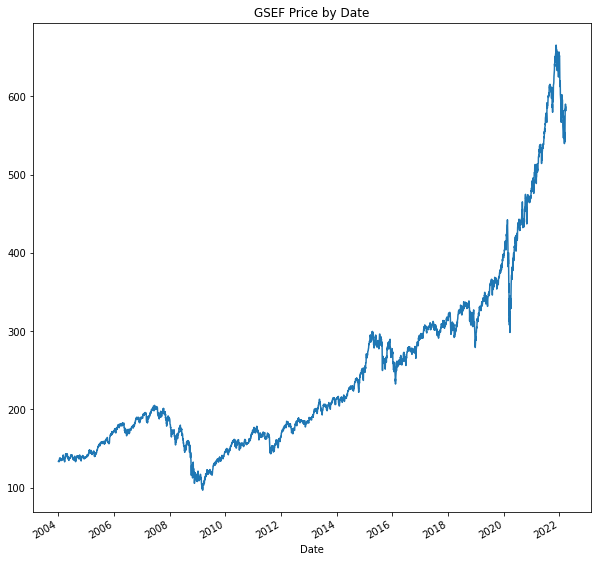

In [11]:
gsef.plot(x= 'Date', y='Close', figsize=(10,10), title= 'GSEF Price by Date', legend=False)

historical_chart= 'gsef_folder/gsef_historical.png'

import os
if os.path.exists(historical_chart):
  os.remove(historical_chart)
else:
  print("The historical chart didn't exist and it has been created.")

#plt.show()

In [12]:
plt.savefig('gsef_folder/gsef_historical.png')

<Figure size 432x288 with 0 Axes>

# GSEF forecast

This analysis demonstrates the use of ARIMA models to predict the prices of the NN (L) Global Sustainable Equity fund.

## Imports & data loading

In [13]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np

In [14]:
gsef_selected= gsef[['Date','Close']]

In [15]:
y = gsef_selected['Close'].values

## Data splitting

In [16]:
train_data, test_data = gsef_selected[0:int(len(gsef_selected)*0.8)], gsef_selected[int(len(gsef_selected)*0.8):]

# Load/split your data
y_train, y_test = train_test_split(y, train_size= len(train_data))

## Pre-modeling analysis

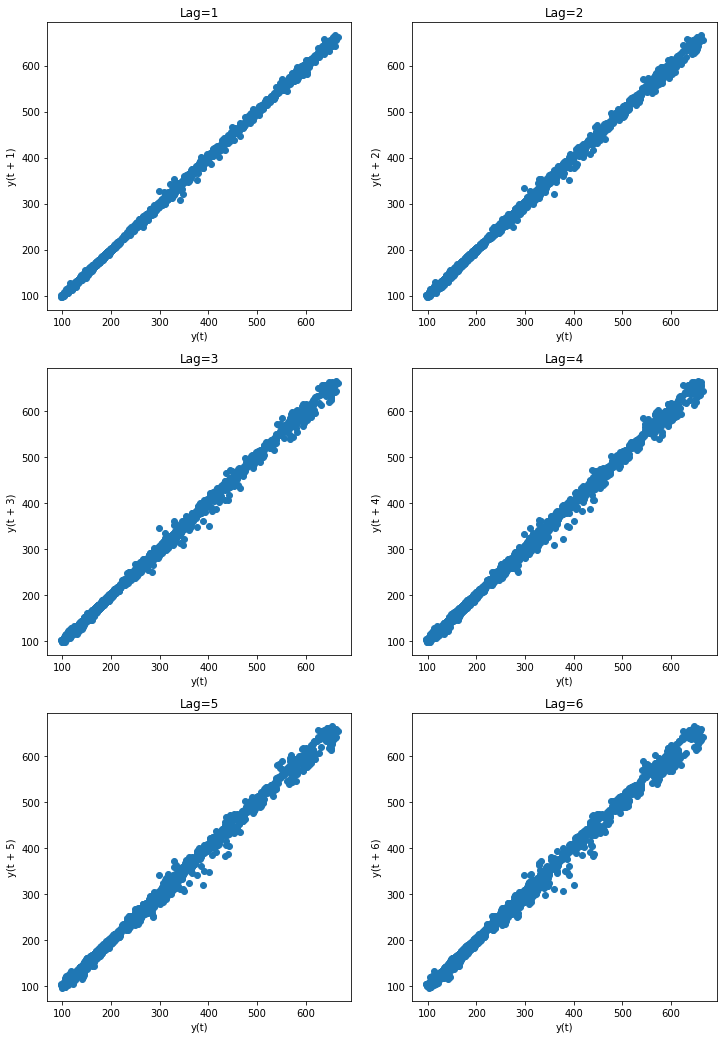

In [17]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
plt.title('GSEF Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(gsef_selected['Close'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

#plt.show()

## Estimating the differencing term

In [18]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


## Fitting our model

In [19]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14759.813, Time=2.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14769.870, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14762.535, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14761.816, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14771.181, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14759.353, Time=1.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14759.264, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14761.186, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14760.021, Time=0.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14760.342, Time=2.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14760.469, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 8.468 seconds


## Updating the model

In [20]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")
# Mean squared error: 28.692414878594857
# SMAPE: 0.8443963447520769

Mean squared error: 28.692414878594857
SMAPE: 0.8443963447520769


In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4599
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -11379.607
Date:                Sun, 27 Mar 2022   AIC                          22767.215
Time:                        22:59:40   BIC                          22792.948
Sample:                             0   HQIC                         22776.272
                               - 4599                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0984      0.045      2.176      0.030       0.010       0.187
ma.L1         -0.0341      0.006     -6.079      0.000      -0.045      -0.023
ma.L2          0.0539      0.006      9.732      0.000       0.043       0.065
sigma2         8.2650      0.058    142.437      0.000       8.151       8.379
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             57731.72
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               7.51   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Viewing forecasts

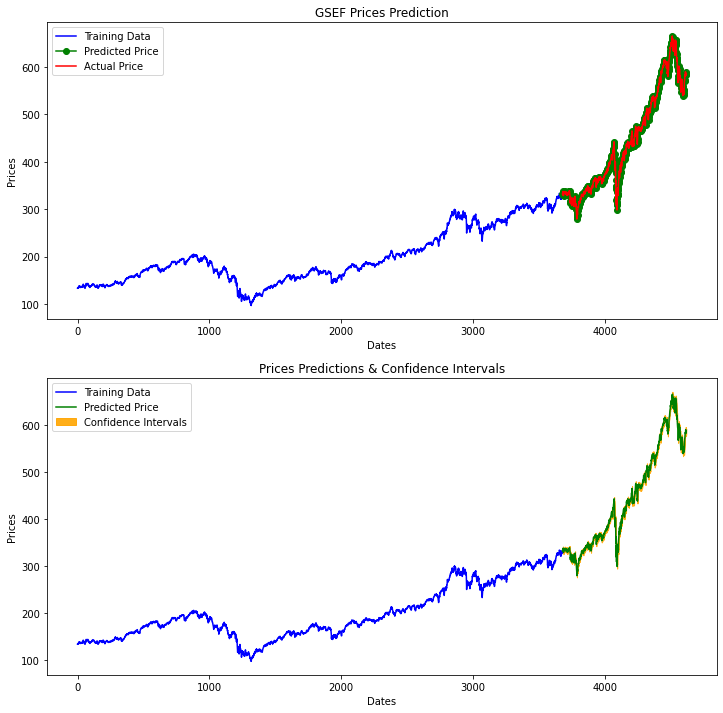

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('GSEF Prices Forecast')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')


axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Forecasts & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()

## Forecast the Price for the next 10 business days

In [23]:
# Forecast the Priece for the next 10 business days
forecast= model.predict(start= len(gsef_selected), end= len(gsef_selected)+10, type= 'levels')

following_day= gsef_selected.Date.iloc[-1]+ pd.DateOffset(1)

index_future_dates= pd.date_range(start= following_day, periods=10, freq='B')

forecast_df = pd.DataFrame(forecast, columns = ['Close'], index= pd.DatetimeIndex(index_future_dates)).reset_index(level=0)

forecast_df.rename(columns={'index': 'Date'}, inplace=True)

existing_with_forecast= pd.concat([gsef_selected, forecast_df], ignore_index=True, sort=False)

## Visualise and save the forecasts

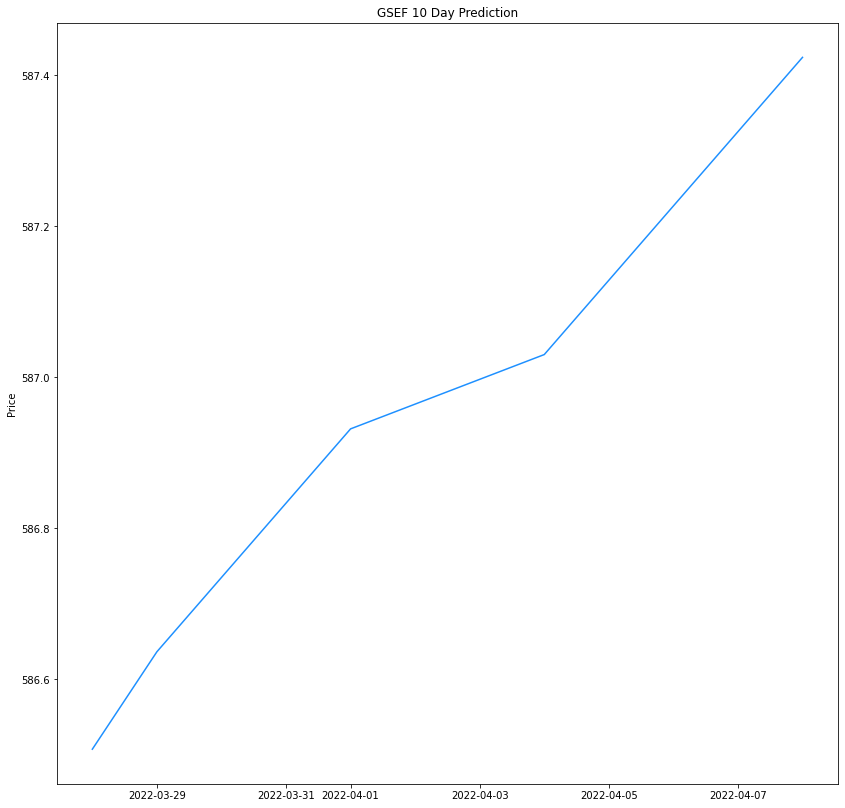

In [24]:
#plt.plot(existing_with_forecast['Date'][:-10], existing_with_forecast['Close'][:-10], color='crimson')

plt.figure(figsize=(18, 18))

plt.plot(existing_with_forecast['Date'][-10:], existing_with_forecast['Close'][-10:], color='dodgerblue')

plt.ylabel('Price')

plt.title('GSEF 10 Business Days Forecast')

forecast_chart= 'gsef_folder/gsef_10_day_forecast.png'

import os
if os.path.exists(forecast_chart):
  os.remove(forecast_chart)
else:
  print("The Forecast chart didn't exist and it has been created.")

plt.savefig('gsef_folder/gsef_10_day_forecast.png', dpi=100)

#plt.show()

## Time Elapsed

In [26]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_minutes = int((time_elapsed % 3600) // 60)

time_elapsed_seconds = int(time_elapsed % 60)

now = datetime.datetime.now()

print("\n Success! Your GSEF data and forecast have been updated in {} minutes and {} seconds on {}".format(time_elapsed_minutes, time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


 Success! Your GSEF data has been updated and 10 days forecast generated in 8 minutes and 0 seconds on 2022-03-27 22:59:42 UTC.
